# Enhanced Correlation Tension Layer

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [4]:
optinua_trails = 20

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def create_enhanced_features(df, target_col='Out'):
    df = df.copy()

    df.interpolate(method='linear', inplace=True)
    new_features = []

    if 'Date' in df.columns or df.index.dtype.kind == 'M':
        date_series = df.index if df.index.dtype.kind == 'M' else pd.to_datetime(df['Date'])
        date_features = pd.DataFrame({
            'Day': date_series.day,
            'Month': date_series.month,
            'Year': date_series.year
        }, index=df.index)
        new_features.append(date_features)

    if target_col in df.columns:
        rolling_features = {}
        for window in [3, 7, 21, 42, 63]:
            rolling_features[f'{target_col}_MA{window}'] = df[target_col].rolling(window=window).mean().bfill()
            rolling_features[f'{target_col}_Std{window}'] = df[target_col].rolling(window=window).std().bfill()
        rolling_features[f'{target_col}_Change'] = df[target_col].pct_change().fillna(0)
        new_features.append(pd.DataFrame(rolling_features, index=df.index))

    lag_features = {}
    for lag in [1, 3, 7, 14, 21, 42, 63]:
        lag_features[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    new_features.append(pd.DataFrame(lag_features, index=df.index))

    df_enhanced = pd.concat([df] + new_features, axis=1)

    numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()

    squared_terms = {f'{col}_squared': df_enhanced[col] ** 2 for col in numeric_cols if col != target_col}
    new_features.append(pd.DataFrame(squared_terms, index=df_enhanced.index))

    interaction_terms = {}
    for i, col1 in enumerate(numeric_cols):
        if col1 == target_col:
            continue
        for col2 in numeric_cols[i+1:]:
            if col2 == target_col:
                continue
            interaction_terms[f'{col1}_{col2}_interact'] = df_enhanced[col1] * df_enhanced[col2]
    new_features.append(pd.DataFrame(interaction_terms, index=df_enhanced.index))

    df_enhanced = pd.concat([df_enhanced] + new_features[-2:], axis=1)

    correlations = {}
    for column in df_enhanced.columns:
        if column != target_col and df_enhanced[column].dtype.kind in 'bifc':
            if df_enhanced[column].std() == 0:
                correlations[column] = 0
            else:
                correlation = pearsonr(df_enhanced[column].fillna(0), df_enhanced[target_col])[0]
                correlations[column] = correlation if not np.isnan(correlation) else 0
    corr_columns = pd.DataFrame(
        {f'Corr_{column}': np.full(len(df_enhanced), correlations[column]) for column in correlations},
        index=df_enhanced.index
    )
    df_enhanced = pd.concat([df_enhanced, corr_columns], axis=1)

    df_enhanced = df_enhanced.dropna()

    return df_enhanced

In [6]:
class CorrelationTensorLayer(nn.Module):
    def __init__(self, feature_count):
        super(CorrelationTensorLayer, self).__init__()
        self.feature_count = feature_count
        self.correlation_weights = nn.Parameter(torch.empty(feature_count, feature_count))
        nn.init.xavier_uniform_(self.correlation_weights)

    def forward(self, inputs):
        batch_size, time_steps, features = inputs.size()
        reshaped = inputs.view(-1, features)
        mean_features = reshaped.mean(dim=0, keepdim=True)
        centered = reshaped - mean_features
        covariance = (centered.t() @ centered) / reshaped.size(0)
        std_devs = torch.sqrt((centered ** 2).mean(dim=0))
        outer_std = std_devs.unsqueeze(1) * std_devs.unsqueeze(0)
        corr_matrix = covariance / (outer_std + 1e-8)
        weighted_corr = corr_matrix * self.correlation_weights
        corr_tensors = weighted_corr.unsqueeze(0).expand(batch_size, -1, -1)
        enhanced_features = corr_tensors.sum(dim=-1)
        enhanced_features = enhanced_features.unsqueeze(1)
        out = torch.cat([inputs, enhanced_features], dim=-1)
        return out

In [7]:
class RefinedTemporalTimeMasterModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim=128, num_layers=2, dropout_rate=0.3, num_heads=4):
        """
        feature_dim: original number of features before correlation layer
        hidden_dim: GRU hidden dimension (will be doubled due to bidirectionality)
        num_layers: number of GRU layers
        dropout_rate: dropout probability
        num_heads: number of heads for multi-head attention (must divide hidden_dim*2)
        """
        super(RefinedTemporalTimeMasterModel, self).__init__()
        self.corr_layer = CorrelationTensorLayer(feature_dim)
        self.bi_gru = nn.GRU(
            input_size=feature_dim * 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        embed_dim = hidden_dim * 2
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(embed_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.corr_layer(x)
        gru_out, _ = self.bi_gru(x)
        attn_output, attn_weights = self.multihead_attn(gru_out, gru_out, gru_out)
        context = attn_output.mean(dim=1)
        x = self.dropout(context)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [8]:
def train_refined_timemaster_sales_model_optuna(df, target_col, test_size, epochs, batch_size, device, model_params, tuning=False):
    """
    Trains the multi-head attention model.
    model_params: dict with keys: hidden_dim, num_layers, dropout_rate, num_heads, learning_rate
    tuning: if True, less verbose output for hyperparameter tuning.
    """
    df_processed = create_enhanced_features(df, target_col)
    feature_cols = df_processed.columns.drop(target_col)
    X = df_processed[feature_cols].values
    y = df_processed[target_col].values.reshape(-1, 1)

    X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    X = np.clip(X, -1e6, 1e6)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    train_size = int((1 - test_size) * X_scaled.shape[0])
    X_train = X_scaled[:train_size]
    X_val = X_scaled[train_size:]
    y_train = y_scaled[:train_size]
    y_val = y_scaled[train_size:]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

    feature_dim = X_train_tensor.shape[2]
    model = RefinedTemporalTimeMasterModel(
        feature_dim=feature_dim,
        hidden_dim=model_params['hidden_dim'],
        num_layers=model_params['num_layers'],
        dropout_rate=model_params['dropout_rate'],
        num_heads=1
    ).to(device)

    if hasattr(optim, 'NAdam'):
        optimizer = optim.NAdam(model.parameters(), lr=model_params['learning_rate'])
    else:
        optimizer = optim.Adam(model.parameters(), lr=model_params['learning_rate'])
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                     patience=10, min_lr=1e-6)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = np.inf
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    patience = 20
    counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_loss = np.mean(train_losses)

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
            val_loss = criterion(val_preds, y_val_tensor).item()

        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                if not tuning:
                    print(f"Early stopping at epoch {epoch+1}")
                break

        if not tuning:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor).cpu().numpy()
    y_val_inv = scaler_y.inverse_transform(y_val_tensor.cpu().numpy())
    y_val_pred_inv = scaler_y.inverse_transform(y_val_pred)
    mse_val = mean_squared_error(y_val_inv, y_val_pred_inv)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val_inv, y_val_pred_inv)
    r2_val = r2_score(y_val_inv, y_val_pred_inv)
    metrics = {"mse": mse_val, "rmse": rmse_val, "mae": mae_val, "r2": r2_val}

    return {
        "model": model,
        "history": history,
        "metrics": metrics,
        "scalers": {"X": scaler_X, "y": scaler_y},
        "feature_cols": feature_cols,
        "X_val": X_val_tensor.cpu().numpy(),
        "y_val": y_val_tensor.cpu().numpy(),
        "y_val_pred": y_val_pred,
        "y_val_inv": y_val_inv,
        "y_val_pred_inv": y_val_pred_inv
    }

In [9]:
def objective(trial):
    model_params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [128, 256 , 512]),
        'num_layers': trial.suggest_int('num_layers', 2, 8),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    }
    result = train_refined_timemaster_sales_model_optuna(
        df,
        target_col=target_col,
        test_size=0.2,
        epochs=50,
        batch_size=32,
        device=device,
        model_params=model_params,
        tuning=True
    )
    return result['metrics']['mse']

In [10]:
data_path = r"/content/Data.csv"
df = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date")

target_col = 'Out'

In [11]:
enhaced_df = create_enhanced_features(df, target_col)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [15]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=optinua_trails)
print("Best hyperparameters:", study.best_params)

best_params = study.best_params

[I 2025-05-08 14:59:16,479] A new study created in memory with name: no-name-3e34df50-3dd6-4473-84cc-607547992fac
[I 2025-05-08 14:59:50,476] Trial 0 finished with value: 634.7711791992188 and parameters: {'hidden_dim': 256, 'num_layers': 8, 'dropout_rate': 0.1671795364864586, 'learning_rate': 0.00781105376648361}. Best is trial 0 with value: 634.7711791992188.
[I 2025-05-08 15:00:06,987] Trial 1 finished with value: 2159.07080078125 and parameters: {'hidden_dim': 128, 'num_layers': 8, 'dropout_rate': 0.17706513217801256, 'learning_rate': 0.0029019602573116623}. Best is trial 0 with value: 634.7711791992188.
[I 2025-05-08 15:00:23,894] Trial 2 finished with value: 396.273193359375 and parameters: {'hidden_dim': 128, 'num_layers': 8, 'dropout_rate': 0.48598021753376686, 'learning_rate': 0.004241699519799716}. Best is trial 2 with value: 396.273193359375.
[I 2025-05-08 15:00:52,353] Trial 3 finished with value: 35.20970916748047 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropo

Best hyperparameters: {'hidden_dim': 256, 'num_layers': 5, 'dropout_rate': 0.4741526848177733, 'learning_rate': 4.756031091090439e-05}


In [16]:
final_result = train_refined_timemaster_sales_model_optuna(
    df=df,
    target_col=target_col,
    test_size=0.2,
    epochs=300,
    batch_size=32,
    device=device,
    model_params=best_params,
    tuning=False
)

Epoch 1/300 - Train Loss: 0.0325 - Val Loss: 0.0238
Epoch 2/300 - Train Loss: 0.0261 - Val Loss: 0.0222
Epoch 3/300 - Train Loss: 0.0257 - Val Loss: 0.0218
Epoch 4/300 - Train Loss: 0.0252 - Val Loss: 0.0215
Epoch 5/300 - Train Loss: 0.0244 - Val Loss: 0.0212
Epoch 6/300 - Train Loss: 0.0235 - Val Loss: 0.0208
Epoch 7/300 - Train Loss: 0.0198 - Val Loss: 0.0028
Epoch 8/300 - Train Loss: 0.0087 - Val Loss: 0.0033
Epoch 9/300 - Train Loss: 0.0050 - Val Loss: 0.0016
Epoch 10/300 - Train Loss: 0.0032 - Val Loss: 0.0011
Epoch 11/300 - Train Loss: 0.0026 - Val Loss: 0.0010
Epoch 12/300 - Train Loss: 0.0020 - Val Loss: 0.0011
Epoch 13/300 - Train Loss: 0.0019 - Val Loss: 0.0008
Epoch 14/300 - Train Loss: 0.0016 - Val Loss: 0.0010
Epoch 15/300 - Train Loss: 0.0016 - Val Loss: 0.0007
Epoch 16/300 - Train Loss: 0.0015 - Val Loss: 0.0006
Epoch 17/300 - Train Loss: 0.0013 - Val Loss: 0.0006
Epoch 18/300 - Train Loss: 0.0012 - Val Loss: 0.0021
Epoch 19/300 - Train Loss: 0.0015 - Val Loss: 0.0005
Ep

In [17]:
# Save scalers and feature columns to a pickle file
save_dict = {
    "scalers": final_result['scalers'],
    "feature_cols": list(final_result['feature_cols'])
}
with open(r"./result_scalers.pkl", "wb") as file:
    pickle.dump(save_dict, file)
print("Scalers and feature columns saved to result_scalers.pkl")

# Save the trained model's state dict
torch.save(final_result['model'].state_dict(), r"./refined_timemaster_sales_model.pth")
print("Model saved to refined_timemaster_sales_model.pth")

In [19]:
# Print evaluation metrics
metrics = final_result['metrics']
print("\n--- Final Model Evaluation ---")
print(f"MSE: {metrics['mse']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"MAE: {metrics['mae']:.4f}")
print(f"R²: {metrics['r2']:.4f}")


--- Final Model Evaluation ---
MSE: 13.8491
RMSE: 3.7214
MAE: 2.9452
R²: 0.9533


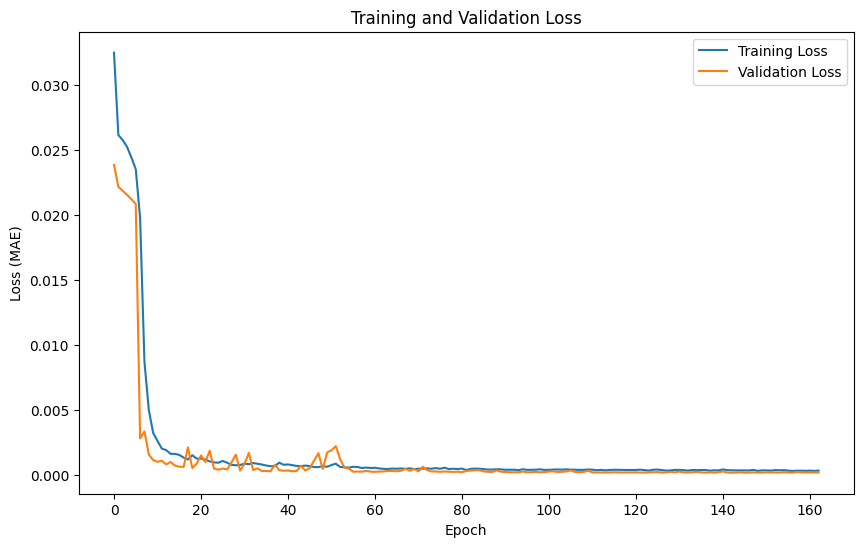

Training MAE: 2.9451606273651123


In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(final_result['history']['train_loss'], label='Training Loss')
plt.plot(final_result['history']['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print("Training MAE:", final_result['metrics']['mae'])


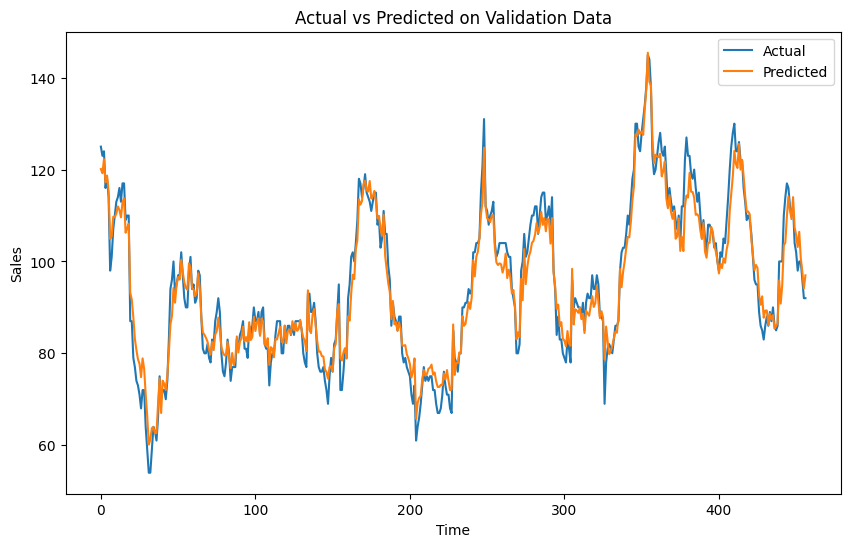

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(final_result['y_val_inv'], label='Actual')
plt.plot(final_result['y_val_pred_inv'], label='Predicted')
plt.title('Actual vs Predicted on Validation Data')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()